# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

## Ziel: 
### Analyse der Hauptrezeptesammlung von über 300'000 verschiedenen Rezepten (3.Teil)

In [11]:
!pip install seaborn

In [3]:
# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import matplotlib.pylab as pylab
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Bereinigung

1. Die Spalte *average_rating* soll nur noch die letzte Zahl enthalten. "n Bewertungen - Ø" kann gelöscht werden da die Anzahl Bewertungen in der Spalte *votes* gespeichert ist.
2. Von der Spalte *stars_shown* kann der substring 'star-' gelöscht werden. Danach in Typ Category umwandeln.
3. Die Klammern sind nicht von Gebrauch in *votes*.
4. *difficulty* kann in eine Category umgewandelt werden.
5. *preparation_time*: substring ' min.' kann gelöscht werden.
6. *date* kann in datetime umgewandelt werden.
7. *has_picture* kann in eine Category umgewandelt werden.
8. Bereinige 'recipe-' von *recipe_id*
9. Die Spalte *link* ist nicht von Bedeutung für Data Analysis und wird entfernt.

In [ ]:
# 1
rezepte['average_rating'] = rezepte['average_rating'].apply(lambda x: x.replace(" Bewertungen - Ø ", ":"))
rezepte['average_rating'] = rezepte['average_rating'].apply(lambda x: x.replace(" Bewertung - Ø ", ":"))
rezepte['average_rating'].replace(to_replace='(.*?):', value='',inplace=True,regex=True)
rezepte['average_rating'] = rezepte['average_rating'].astype('float64')

# 2
rezepte['stars_shown'] = rezepte['stars_shown'].apply(lambda x: x.replace("star-", ""))
rezepte['stars_shown'] = rezepte['stars_shown'].astype('category')

# 3
rezepte['votes'] = rezepte['votes'].str.extract('(\d+)')
rezepte['votes'] = rezepte['votes'].astype('float64')

# 4
rezepte['difficulty'] = rezepte['difficulty'].astype('category')

# 5
rezepte['preparation_time'] = rezepte['preparation_time'].apply(lambda x: x.replace(" min.", "")).astype('float64')

# 6
rezepte['date'] = pd.to_datetime(rezepte['date'])

# 7
rezepte['has_picture'] = rezepte['has_picture'].astype('category')

# 8
rezepte['recipe_id'] = rezepte['recipe_id'].apply(lambda x: x.replace("recipe-", ""))

# 9
rezepte.drop(rezepte.columns[[-2]], axis=1, inplace=True)

In [4]:
rezepte = pd.read_csv('/input/chefkoch_rezepte_analysis.csv')

In [7]:
rezepte.head()

,Unnamed: 0,recipe_id,recipe_name,average_rating,stars_shown,votes,difficulty,preparation_time,date,has_picture
0,0,3449791514066439,Bratapfel-Rotkohl,2.5,unb,0.0,normal,45.0,2017-12-24,no
1,1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2.5,unb,0.0,pfiffig,15.0,2017-12-24,no
2,2,3449701514054063,Deichgrafensalat von der Westküste,2.5,unb,0.0,normal,30.0,2017-12-24,no
3,3,3449651514047893,Geschichteter Kohl,2.5,unb,0.0,normal,40.0,2017-12-24,no
4,4,3449681514052511,Rinderlendenragout,2.5,unb,0.0,normal,15.0,2017-12-24,no


In [9]:
rezepte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316755 entries, 0 to 316754
Data columns (total 9 columns):
recipe_id           316755 non-null int64
recipe_name         316755 non-null object
average_rating      316755 non-null float64
stars_shown         316755 non-null object
votes               316755 non-null float64
difficulty          316755 non-null object
preparation_time    316755 non-null float64
date                316755 non-null object
has_picture         316527 non-null object
dtypes: float64(3), int64(1), object(5)
memory usage: 24.2+ MB


In [5]:
rezepte.drop(rezepte.columns[[0]], axis=1, inplace=True)
rezepte.drop_duplicates(subset=['recipe_id'], keep='first', inplace=True)
rezepte.head()

,recipe_id,recipe_name,average_rating,stars_shown,votes,difficulty,preparation_time,date,has_picture
0,3449791514066439,Bratapfel-Rotkohl,2.5,unb,0.0,normal,45.0,2017-12-24,no
1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2.5,unb,0.0,pfiffig,15.0,2017-12-24,no
2,3449701514054063,Deichgrafensalat von der Westküste,2.5,unb,0.0,normal,30.0,2017-12-24,no
3,3449651514047893,Geschichteter Kohl,2.5,unb,0.0,normal,40.0,2017-12-24,no
4,3449681514052511,Rinderlendenragout,2.5,unb,0.0,normal,15.0,2017-12-24,no


In [109]:
rezepte.recipe_id.value_counts()[:20]

347111119278630     1
2357751374670382    1
1922151313497059    1
2460121387272014    1
2938521446134839    1
3106511463513434    1
2845031436536893    1
328751115500591     1
674611169741626     1
203151085744570     1
3076171460279540    1
2295001365854624    1
3250141483556854    1
612691161247144     1
1927871314190314    1
2899111442244685    1
449491137318517     1
1386851243779752    1
1392671244280062    1
60671022158473      1
Name: recipe_id, dtype: int64

In [7]:
rezepte['date'] = pd.to_datetime(rezepte['date'])
rezepte['year'] = rezepte['date'].map(lambda x: x.year)

In [8]:
rezepte.head(2)

,recipe_id,recipe_name,average_rating,stars_shown,votes,difficulty,preparation_time,date,has_picture,year
0,3449791514066439,Bratapfel-Rotkohl,2.5,unb,0.0,normal,45.0,2017-12-24,no,2017
1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2.5,unb,0.0,pfiffig,15.0,2017-12-24,no,2017


In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

In [10]:
#!pip install statsmodels
!pip install ggplot

In [105]:
import pandas as pd
import re
import statsmodels as sm


from ggplot import *
theme_bw()

import matplotlib.pyplot as mpl
mpl.style.use('ggplot')
%matplotlib inline

(0, 17.5)

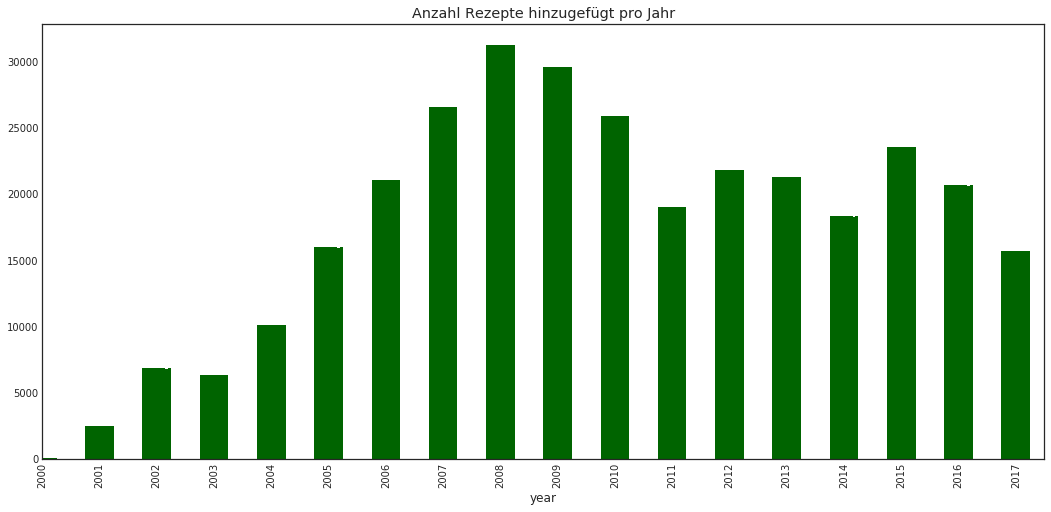

In [28]:
rezepte.groupby('year').count().plot(kind='bar', color='darkgreen', title="Anzahl Rezepte hinzugefügt pro Jahr", legend=None).set_xlim(0)

In [12]:
rezepte['YearMonth'] = rezepte['date'].map(lambda x: 1000*x.year + x.month)

In [34]:
rezepte['YearMonth'].head()

0    2017012
1    2017012
2    2017012
3    2017012
4    2017012
Name: YearMonth, dtype: int64

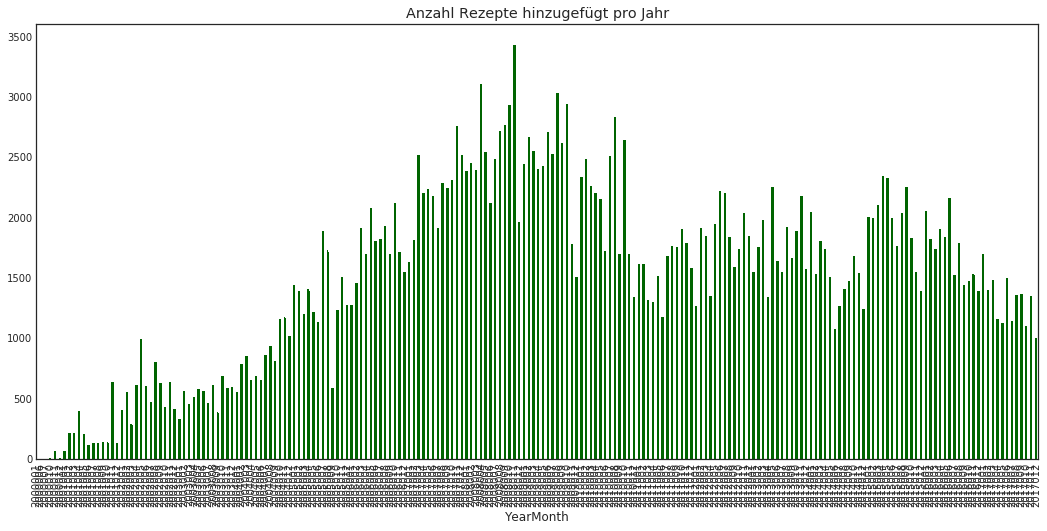

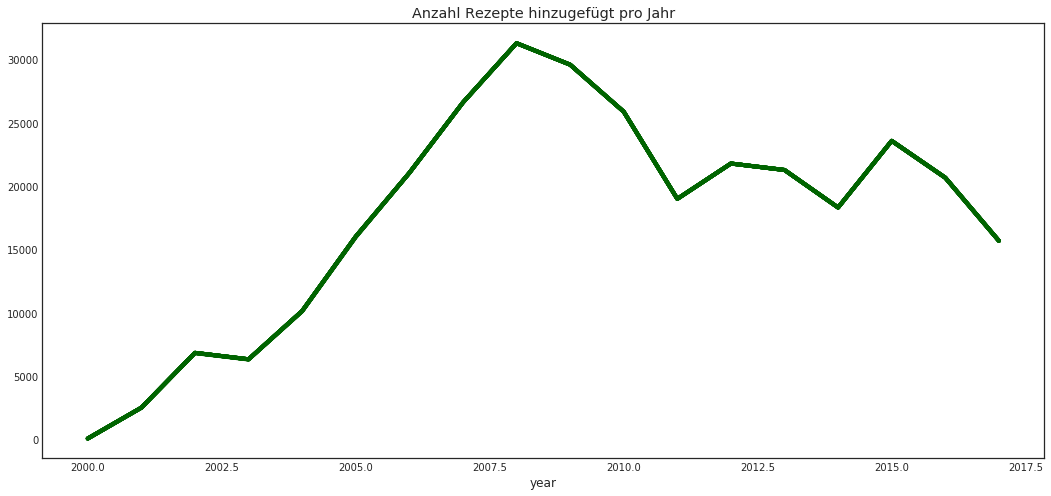

In [45]:
fig = plt.figure()
rezepte.groupby('YearMonth').count().plot(kind='bar', color='darkgreen', title="Anzahl Rezepte hinzugefügt pro Jahr", legend=None).set_xlim(0)
rezepte.groupby('year').count().plot(color='darkgreen', title="Anzahl Rezepte hinzugefügt pro Jahr", legend=None)
#ax1 = plt.axes()
#x_axis = ax1.axes.get_xaxis()
#x_axis.set_visible(False)
#for label in x_axis.get_ticklabels()[::2]:
#    label.set_visible(False)
plt.show()

<bound method Artist.set of <matplotlib.axes._subplots.AxesSubplot object at 0x7fb153a4a5c0>>

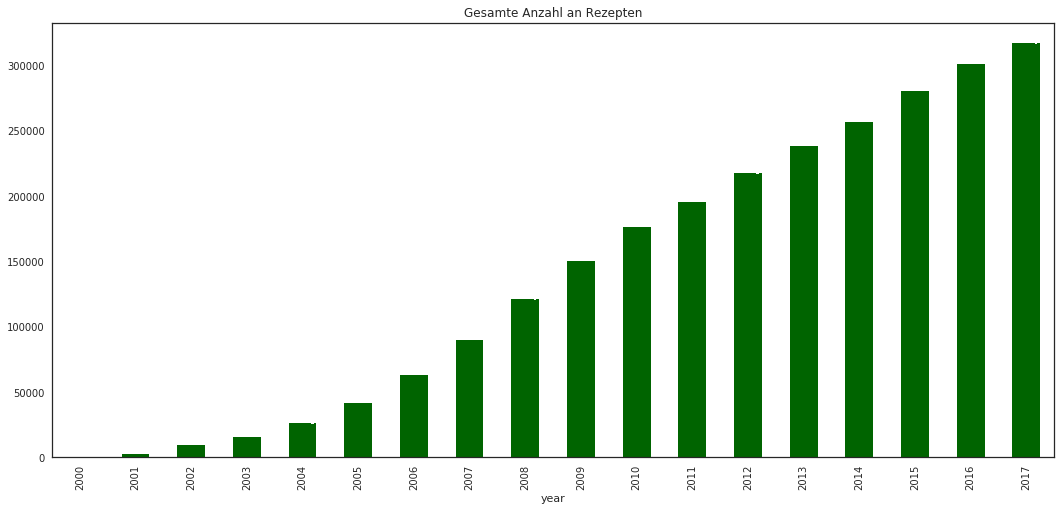

In [146]:
rezepte.sort_values(by='year', ascending=True).groupby('year').count().cumsum(0).plot(kind='bar', color='darkgreen', title='Gesamte Anzahl an Rezepten', legend=None).set

In [91]:
rezepte['new_rating'] = [rezepte['average_rating'][i] if x > 0 else 0 for i, x in enumerate(rezepte['votes'])]

(0, 5.1135000000000002)

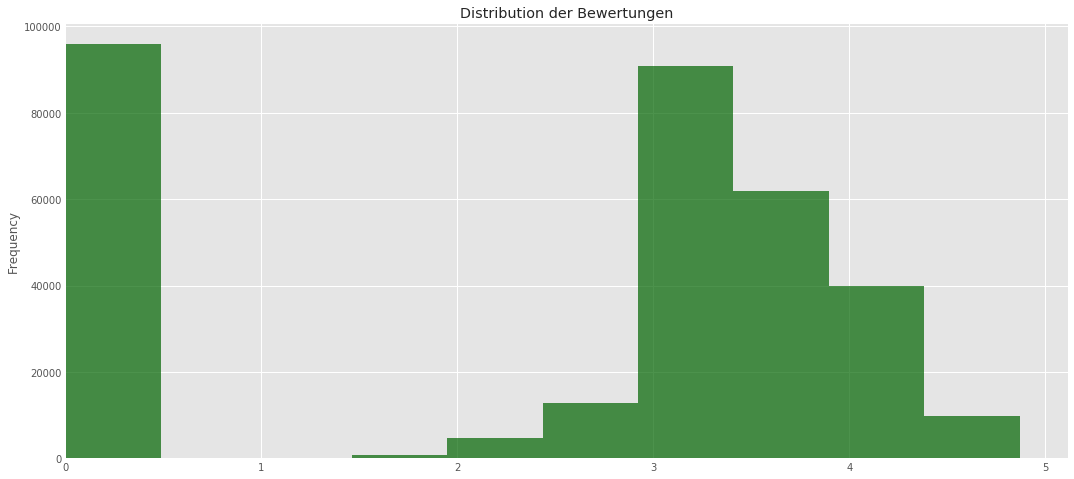

In [112]:
rezepte.plot(kind='hist', y='new_rating',
        color='darkgreen', alpha=0.7, legend=None,
        title='Distribution der Bewertungen').set_xlim(0)

(0, 3449.2499999999995)

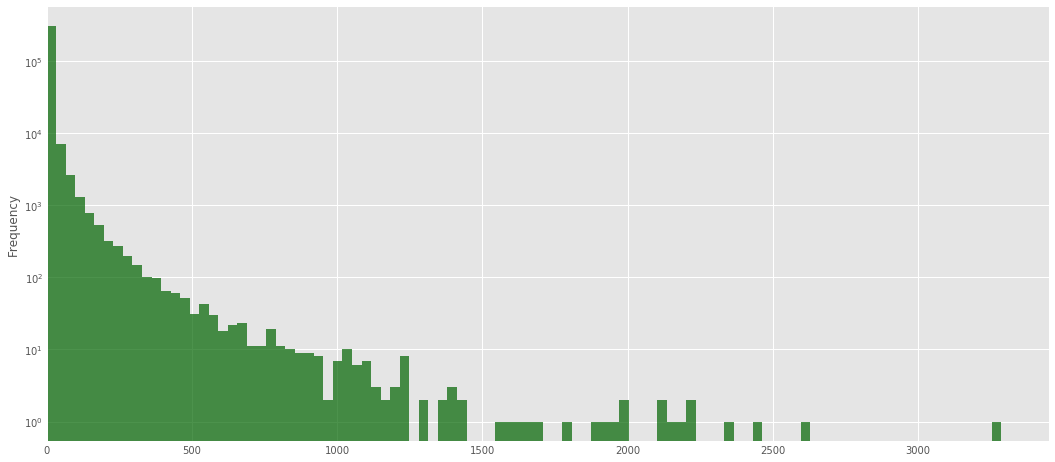

In [113]:
rezepte.plot(kind='hist', y='votes', 
        bins=100, logy=True,
        legend=None, color='darkgreen', alpha=0.7).set_xlim(0)

In [125]:
from itertools import cycle, islice
my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, 10))

(0, 17.5)

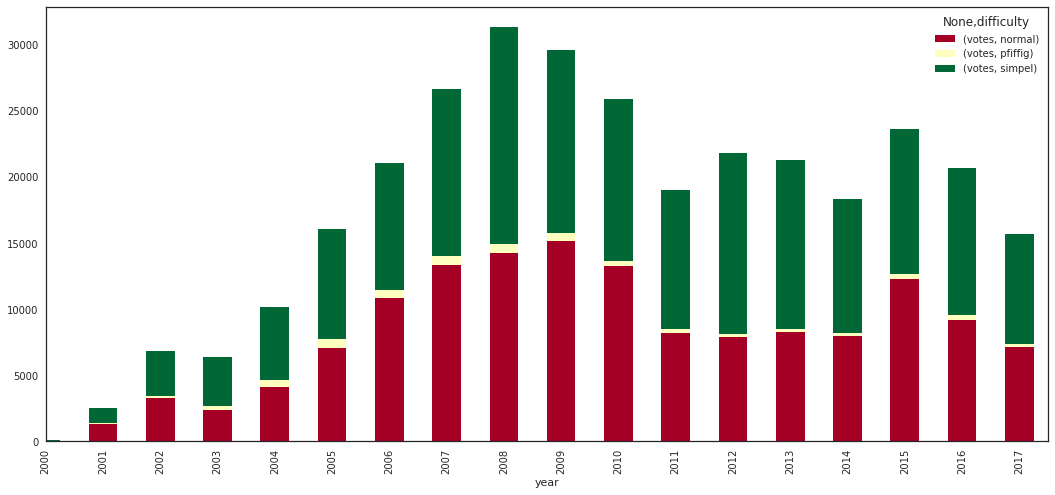

In [153]:
rezepte[['votes','difficulty','year']].groupby(['year','difficulty']).count().unstack().plot(kind='bar',colormap='RdYlGn',stacked=True).set_xlim(0)

In [130]:
rezepte.head()

,recipe_id,recipe_name,average_rating,stars_shown,votes,difficulty,preparation_time,date,has_picture,year,new_rating
0,3449791514066439,Bratapfel-Rotkohl,2.5,unb,0.0,normal,45.0,2017-12-24,no,2017,0.0
1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2.5,unb,0.0,pfiffig,15.0,2017-12-24,no,2017,0.0
2,3449701514054063,Deichgrafensalat von der Westküste,2.5,unb,0.0,normal,30.0,2017-12-24,no,2017,0.0
3,3449651514047893,Geschichteter Kohl,2.5,unb,0.0,normal,40.0,2017-12-24,no,2017,0.0
4,3449681514052511,Rinderlendenragout,2.5,unb,0.0,normal,15.0,2017-12-24,no,2017,0.0


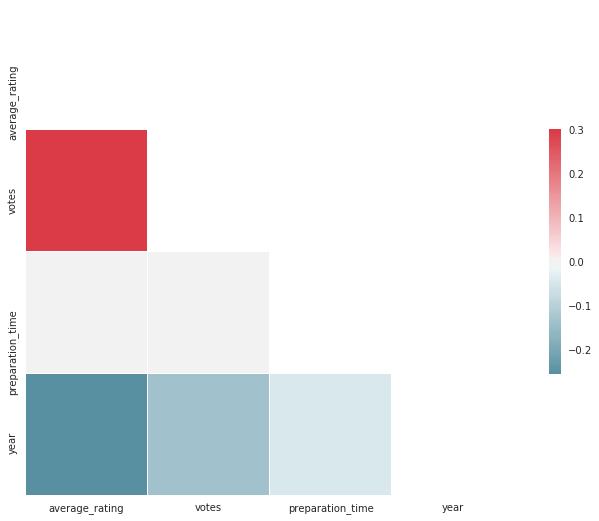

In [134]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
# Compute the correlation matrix
corr = rezepte.drop(['new_rating', 'recipe_id'], 1).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# heatmap with mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [169]:
def plot_correlation_map(df):
    corr = rezepte.drop(['new_rating', 'recipe_id'], 1).corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ))
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 })

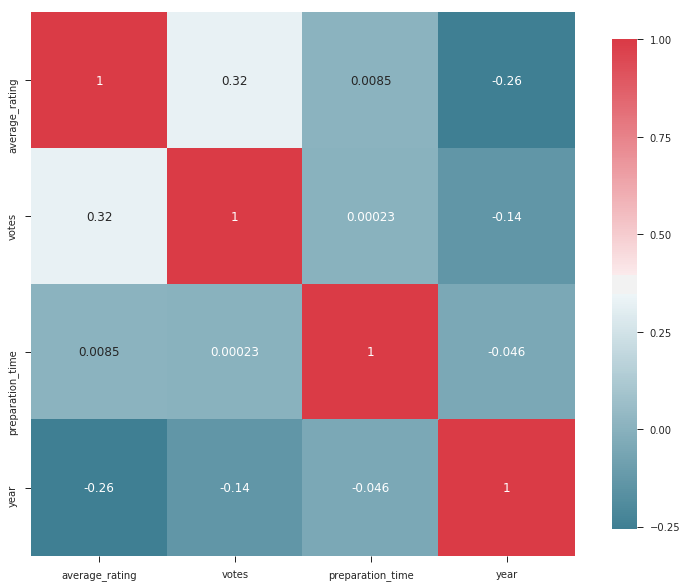

In [170]:
plot_correlation_map(rezepte)

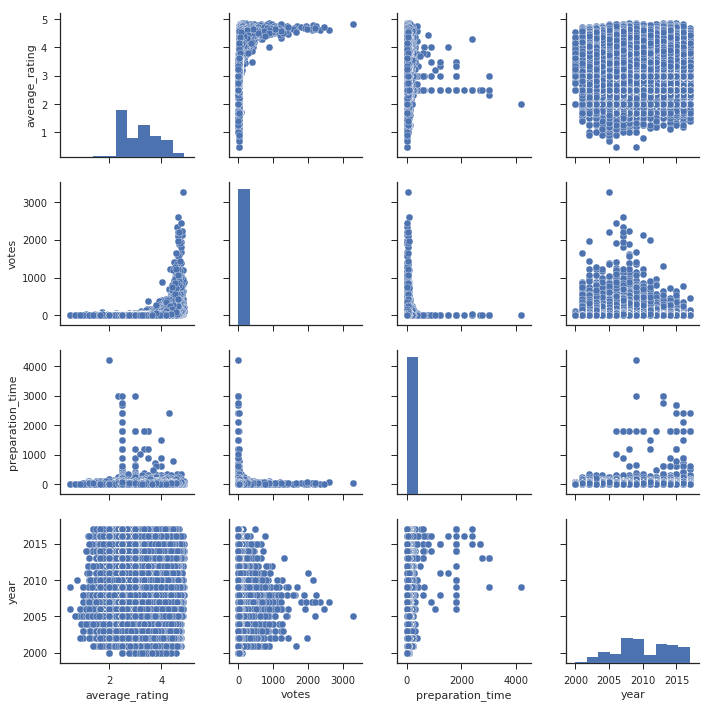

In [155]:
import seaborn as sns; sns.set(style='ticks', color_codes=True)
g = sns.pairplot(rezepte.drop(['new_rating', 'recipe_id'], 1))

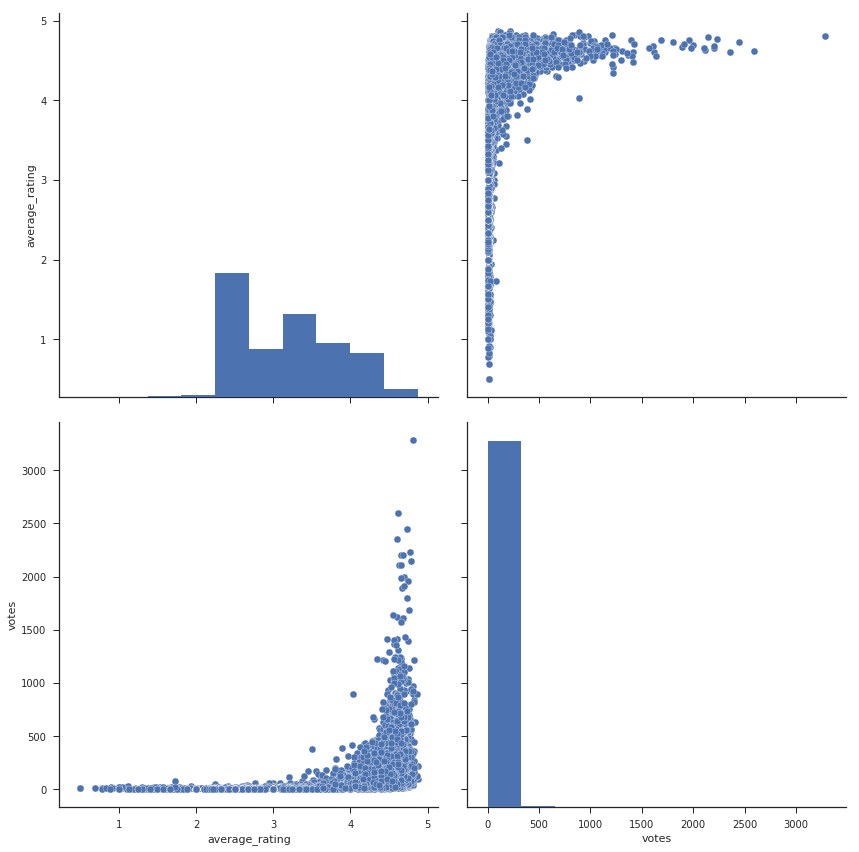

In [166]:
f = sns.pairplot(rezepte[['average_rating', 'votes']], size=6)

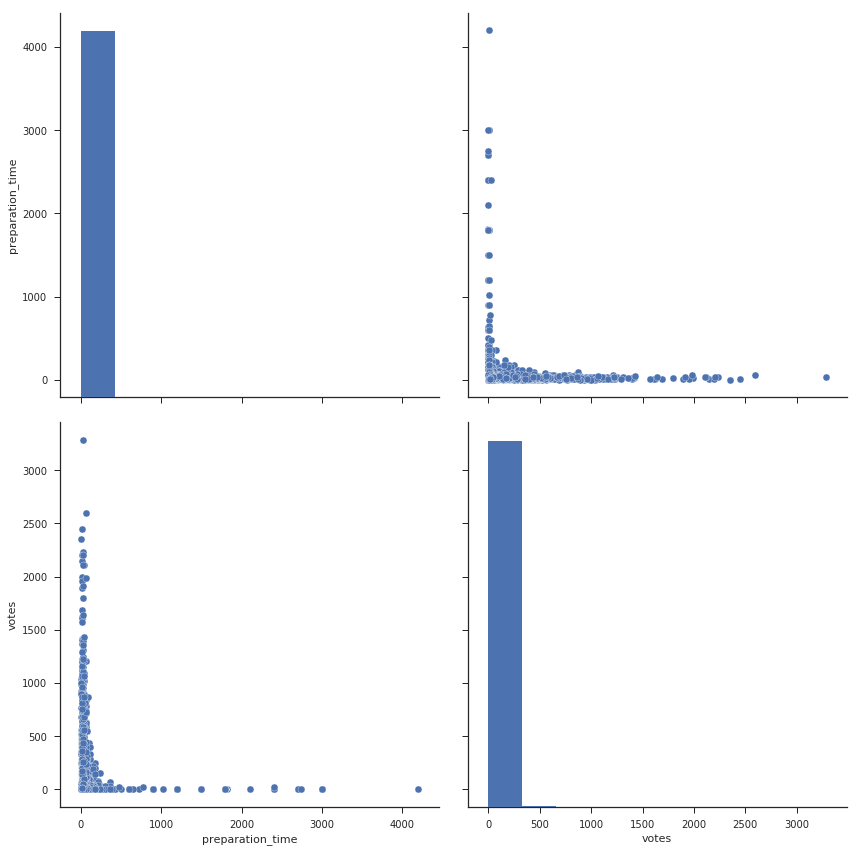

In [168]:
f = sns.pairplot(rezepte[['preparation_time', 'votes']], size=6)